In [5]:
import sys
import os
base_path = "/home/ubuntu/Projects/RL_sim/"
sys.path.insert(0, base_path)
os.chdir(base_path)

from agents.soft_q_learner import SoftQAgent
from agents.utils import *
from PIL.ImageOps import invert
from posixpath import join
from PIL import Image
from IPython import display

import matplotlib.pyplot as plt
import gymnasium as gym
import checkerboard_env
import pandas as pd
import numpy as np
import time

In [6]:
from itertools import product

# Add parameter search;
parameters = {
    'snr': [3.31],
    'n_bins': [10],
    'q_mean': [0],
    'q_sigma': [0.1],
    'kernel_size': [20],
    'kernel_sigma': [2.0],
    'learning_rate': [0.3],
    'temperature': [0.001],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# Generate all possible combinations
combinations = list(product(*parameters.values()))

# Convert the combinations into a list of dictionaries
parameter_combinations = [dict(zip(parameters.keys(), values)) for values in combinations]

# use one combination:
params = parameter_combinations[0]

In [7]:
def load_checkerboard(img, cross):
    
    board = Image.open(img)
    cross = Image.open(cross)

    if board.mode == 'RGBA':
        r,g,b,a = board.split()
        rgb_image = Image.merge('RGB', (r,g,b))
        rgb_inverse = invert(rgb_image)

        r2,g2,b2 = rgb_inverse.split()
        inverse = Image.merge('RGBA', (r2,g2,b2,a))

    else:
        inverse = invert(board)
    
    return board, inverse, cross

In [10]:
def euclidean_2D(x, v):
    x = np.array(x)
    v = np.array(v)
    distance = np.linalg.norm(x - v, axis=1)
    return np.mean(distance)

def test_convergence(maxima, current_window_size):
    previous_window = maxima[-current_window_size:-1]
    current_window = maxima[-(current_window_size - 1):]
    return euclidean_2D(previous_window, current_window)

0.0


KeyboardInterrupt: 

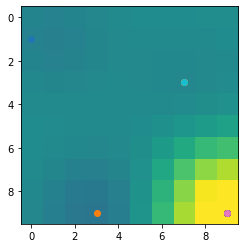

In [11]:
assets_path = "checkerboard_env/assets/"
board, inverse, cross = load_checkerboard(
    join(base_path, assets_path + "checkerboard.png"),
    join(base_path, assets_path + "cross.png")
)

env = gym.make('checkerboard-v0',
        render_mode=None,
        checkerboard=board,
        inverse=inverse,
        cross=cross,
        snr=params["snr"])

NUM_BINS = params["n_bins"]
BINS = create_bins(NUM_BINS)

q_table_shape = (NUM_BINS, NUM_BINS)  # contrast * frequency;
# q_table = np.random.normal(params["q_mean"], params["q_sigma"], q_table_shape)
q_table = np.ones(q_table_shape)*0.5
kernel = generate_gaussian_kernel(params["kernel_size"], params["kernel_sigma"])

model = SoftQAgent(
    env,
    q_table,
    kernel,
    learning_rate=params["learning_rate"],
    temperature=params["temperature"],
    min_temperature=params["min_temperature"],
    max_temperature=params["max_temperature"],
    reduce_temperature=params["reduce_temperature"],
    decay_rate=params["decay_rate"],
    num_bins_per_obs=NUM_BINS
)

initial_state = model.env.reset()[0]
discrete_state = discretize_observation(initial_state, BINS)

# Create a figure for the Q-table visualization
fig, ax = plt.subplots()

n_epochs = 100
window = 5
maxima = []

# fit the model;
for current_epoch in range(n_epochs):
    action = model.soft_q_action_selection()

    (next_state,
    reward,
    terminated,
    truncated,
    info) = model.env.step(action)

    # grab current q-value;
    old_q_value = model.q_table[discrete_state]

    # discretize the next state;
    next_state_discrete = discretize_observation(next_state, BINS)

    # compute next q-value and update q-table;
    model.q_table = model.update_q_table(reward, next_state_discrete, old_q_value)

    # update state;
    discrete_state = next_state_discrete

    # by default keep temperature constant;
    model.reduce_temperature(current_epoch, reduce=model.reduce_temp)
    model.reward_log.append(reward)

    # Display the Q-table
    ax.imshow(model.q_table, cmap='viridis', vmin=0, vmax=1.0)
    ax.plot(action[1]*NUM_BINS, action[0]*NUM_BINS, "o")
    display.display(fig)
    display.clear_output(wait=True)
    
    # compute the norm of the difference from the previous max location to this
    # look at the average of this norm fro the last x (3-5) trials
    max_index = np.unravel_index(np.argmax(model.q_table), q_table_shape)
    maxima.append(max_index)

    if len(maxima) >= window:
        print(test_convergence(maxima, window))
    
    # Optional: You can add a small delay to make the visualization smoother
    time.sleep(0.1)

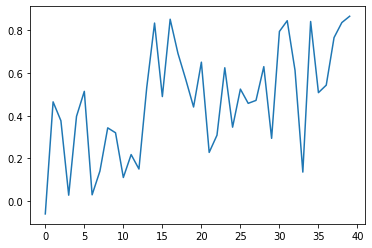

In [ ]:
plt.plot(model.reward_log)